# Rainfall retreival

---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aladinor/Ladino_et_al_2024_DNN_PSD_retrieval/blob/main/notebooks/4.Rain_retrieval.ipynb
)

Sets up the environment and data path based on whether the notebook is running in Colab or locally.

In [1]:
if 'google.colab' in str(get_ipython()):
    !wget https://raw.githubusercontent.com/aladinor/Ladino_et_al_2025_DNN_PSD_retrieval/main/scripts/colab_setup.py -O colab_setup.py
    %run colab_setup.py
    path = '/content/Ladino_et_al_2025_DNN_PSD_retrieval/'
else:
    print("Running notebook locally")
    path = '..'

Running notebook locally


## Imports

In [2]:
import xarray as xr
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.transforms as mtransforms
from tensorflow import keras
from tensorflow.keras import layers
from scipy.special import gamma
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from collections import Counter
from dask.distributed import Client, LocalCluster
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch, Rectangle
from matplotlib.offsetbox import DrawingArea
import warnings
warnings.filterwarnings('ignore')

2025-04-02 15:01:21.943455: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-02 15:01:21.951362: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-02 15:01:21.975573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-02 15:01:22.015358: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-02 15:01:22.027370: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 15:01:22.049661: I tensorflow/core/platform/cpu_feature_gu

In [3]:
# setting up the Seaborne style including figure  dpi
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set(style='white', font_scale=0.9)
sns.set_style("ticks")

### Local Cluster

Let's spin up our `Dask` local cluster

In [4]:
cluster = LocalCluster()  
# display(cluster)

## Data

CAMP2Ex dataset is stored in Analysis-Ready Cloud-Optimized (ARCO) format ([Abernathey et al. 2021](https://ieeexplore.ieee.org/document/9354557)) using [Xarray-Datatree](https://xarray-datatree.readthedocs.io/en/latest/) data model that allows us to have both Learjet and P3B datasets in one `datatree`. Climate and Forecast [(CF)](https://cfconventions.org/) were used to promote the processing and sharing of files created. Results from [K-means cluster](1.K-means-psd.ipynb)  analysis are also loaded into a `Pandas.Dataframe`

In [5]:
dt_camp2ex = xr.open_datatree(
    f'{path}/data/camp2ex_dtree.zarr', 
    engine='zarr', 
    consolidated=True, 
    chunks={},
)
path_kmeans = f'{path}/data/df_cluster.parquet'
df = pd.read_parquet(path_kmeans)

## Deep Neural Network

Our DNN was already trained in [PSD DNN](2.PSD_DNN_Training.ipynb). Thus, we can load the saved model as follows

In [6]:
model = tf.keras.models.load_model(f"{path}/data/dnn_zku_Dfr_ka_16x6.keras")

Simlarly, data for training and testing is copied into `X` variable. `Y` variable is use for data labeling and targeting

In [7]:
X = df[['dbz_t_ku', 'dfr', 'Att_ka', 'log10_nw', 'dm', 'mu_unc']]
Y = df[['dm_class',  'r', 'kmeans', 'time', 'r_dm_gm_mu_3', 'r_gpm_operational', 
        'dm_rt_dfr_gm_mu_3', 'log10nw_dm_gm_mu_3', 'mu_3']]

Let's transform our input parameters by removing the mean and scaling to unit variance using the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from the `Sklearn` Python package as follows

In [8]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'mu_unc']])

Data is splitted into `X_train` and `X_test` as follows

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=40, stratify=df.kmeans)
X_train.shape

(6321, 6)

We can use the `X_test` variable to predict the quantities after training our DNN.

In [10]:
# yhat = model.predict(X_test[:, :4])
yhat = model.predict(X_test[:, :3])

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


DNN input data is scaled. Therefore, we need to apply and inverse transformation. Similarly, data need to be inversely tranformed for the test dataset 

In [11]:
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 3:])

## NGSD parameter retrieval comparison

To compare the NGSD parameters we can create a `pandas.DataFrame` to store results

**Test dataset dataframe**

In [12]:
df_test = pd.DataFrame(data=y_test_unscaled, columns=['log10_nw', 'dm', 'mu'])

**Inference parameters dataframe**

In [13]:
df_est = pd.DataFrame(data=yhat, columns=['log10_nw_hat', 'dm_hat', 'mu_hat'])

We can merge/concatenate both dataframes into a single `pandas.DataFrame`

In [14]:
df_dnn = pd.concat([df_test, df_est, y_test[['kmeans', "time"]].reset_index()], axis=1)

NGSD parameter retrieval is assessed using:

$$error = \hat{y} - y $$

Mean Percentage Error (MPE)

$$MPE = 100* \lvert  \frac{y - \hat{y}}{y} \rvert$$

Where $y$ is the "true" value and $\hat{y}$ is the estimate value

In [15]:
df_dnn['dm_MPE'] = 100 * (df_dnn['dm'] - df_dnn['dm_hat']) /  df_dnn['dm']
df_dnn['dm_pred_err'] =  df_dnn['dm_hat'] - df_dnn['dm']
df_dnn['log10_nw_MPE'] = 100 * (df_dnn['log10_nw'] - df_dnn['log10_nw_hat']) /  df_dnn['log10_nw']
df_dnn['log10_nw_pred_err'] = df_dnn['log10_nw_hat'] -  df_dnn['log10_nw']
df_dnn['mu_MPE'] = 100 * (df_dnn['mu'] - df_dnn['mu_hat']) /  df_dnn['mu']
df_dnn['mu_pred_err']  =  df_dnn['mu_hat'] - df_dnn['mu']

Targeting and labeling variables were stored in `Y`, as well as GPM baseline retrievals computed beforehand. We can create a `pandas.DataFrame` with this information

In [16]:
df_gpm = pd.concat([df_test, y_test.reset_index()], axis=1)

Similarly, we can compute the performance metrics for each legacy retrieval method

In [17]:
df_gpm['dm_MPE'] = 100 * (df_gpm['dm'] - df_gpm['dm_rt_dfr_gm_mu_3']) /  df_gpm['dm']
df_gpm['dm_pred_err'] = df_gpm['dm_rt_dfr_gm_mu_3'] - df_gpm['dm'] 
df_gpm['log10_nw_MPE'] = 100 * (df_gpm['log10_nw'] - df_gpm['log10nw_dm_gm_mu_3']) /  df_gpm['log10_nw']
df_gpm['log10_nw_pred_err'] = df_gpm['log10nw_dm_gm_mu_3'] - df_gpm['log10_nw'] 
df_gpm['mu_MPE'] = 100 * (df_gpm['mu'] - df_gpm['mu_3']) /  df_gpm['mu']
df_gpm['mu_pred_err']  =  df_gpm['mu_3'] - df_gpm['mu'] 

Interquantile ranges (IQR) for DNN and GPM-baseline retreivals are computed as follows

In [18]:
dnn_iqrs = df_dnn[['dm_pred_err', 'log10_nw_pred_err', 'mu_pred_err']].quantile([0.25, 0.5, 0.75])
gpm_iqrs = df_gpm.replace({'log10_nw_pred_err': [np.inf, -np.inf]}, np.nan)[['dm_pred_err', 'log10_nw_pred_err', 'mu_pred_err']].quantile([0.25, 0.5, 0.75])

keys = ['DNN', "GPM-baseline"]
pd.concat([dnn_iqrs, gpm_iqrs], axis=1, levels=[keys], keys=keys)

DNN                               GPM-baseline                    \
     dm_pred_err log10_nw_pred_err mu_pred_err  dm_pred_err log10_nw_pred_err   
0.25   -0.046730         -0.096725   -0.220615     0.048665         33.793867   
0.50   -0.007432          0.041761   -0.053922     0.074011         42.878491   
0.75    0.018548          0.166042    0.104703     0.165721         55.040521   

                  
     mu_pred_err  
0.25   -0.007136  
0.50    3.018473  
0.75    4.816900

Similarly, we can compute the prediction error standard deviation for each parameter at DNN and GPM-Analytical retrieval

In [19]:
dnn_std = df_dnn[['dm_pred_err', 'log10_nw_pred_err', 'mu_pred_err']].std()
gpm_std =  df_gpm.replace({'log10_nw_pred_err': [np.inf, -np.inf]}, np.nan)[['dm_pred_err', 'log10_nw_pred_err', 'mu_pred_err']].std()

keys = ['DNN', "GPM-baseline"]
pd.concat([dnn_std, gpm_std], axis=1, levels=[keys], keys=keys)

,DNN,GPM-baseline
dm_pred_err,0.089800,0.341902
log10_nw_pred_err,0.256015,13.721993
mu_pred_err,0.334656,2.641064


We added a new column with the retrieval source that will allow us to create violing plots using [`seaborn.violinplot`](https://seaborn.pydata.org/generated/seaborn.violinplot.html) colored by source 

In [20]:
df_dnn['source'] = "DNN"
df_gpm['source'] = "GPM-Analytical"

We merge both error dataframes into a single dataframe for plotting purposes

In [21]:
# New merge dataframe
df_plot = pd.concat([df_dnn, df_gpm], axis=0).reset_index(drop=True)
df_plot.replace(-np.inf, np.nan, inplace=True)

## Plotting results

Let's define some figure settings such as colormaps.

In [22]:
# defining the Colormap for each cluster identified
n_c = 6
my_cmap6 = ListedColormap(sns.color_palette('deep', 6))
colors6 = my_cmap6(np.linspace(0,1,6))

We created violin plots to visualize error density distribution for each PSD family across each parameter retreived as follows

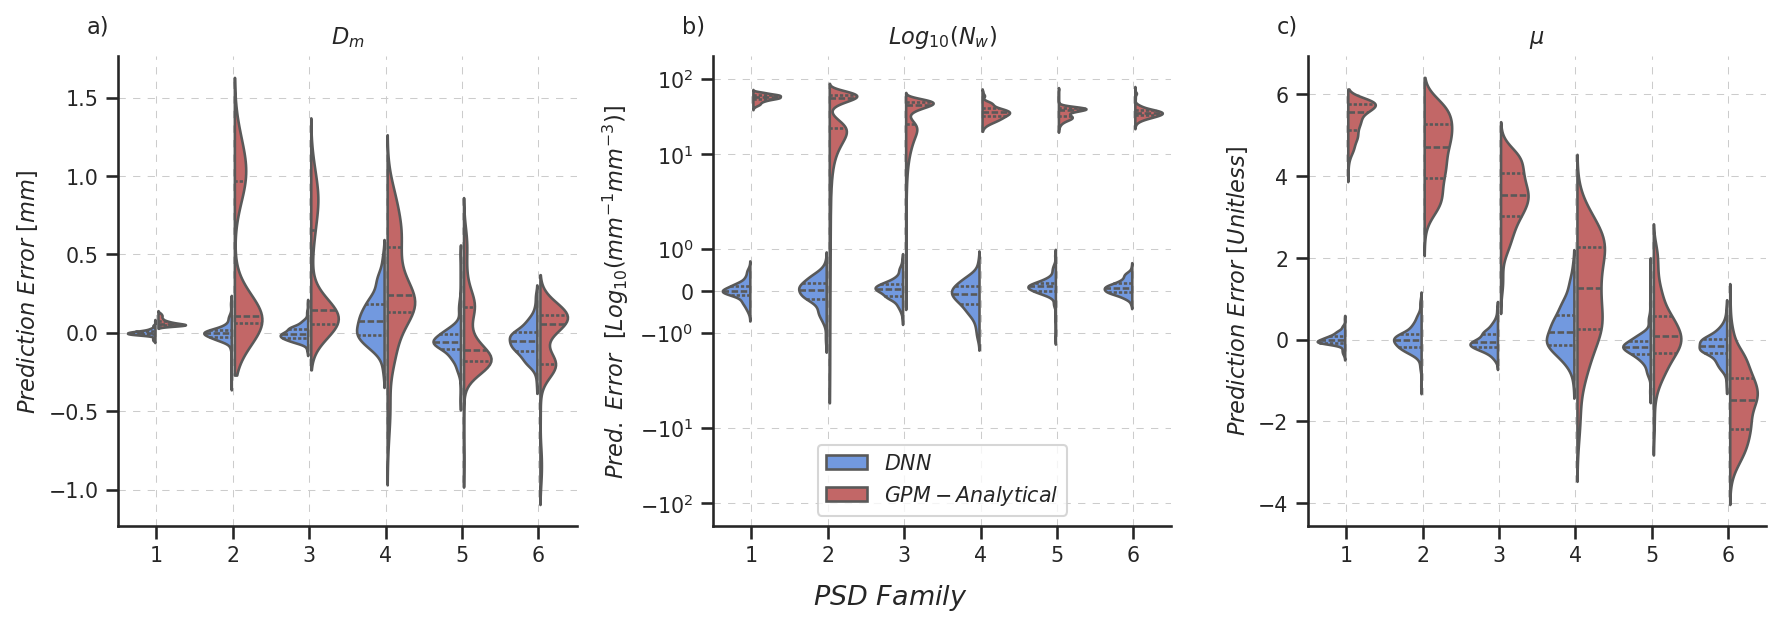

In [23]:
fig, axs = plt.subplot_mosaic([['a)', 'b)', 'c)']], figsize=(12,4.3), dpi=150, sharex=True)

# Dm plot
ax = axs['a)']
sns.violinplot(
    data=df_plot, 
    x='kmeans', y='dm_pred_err', 
    hue='source',
    palette=['cornflowerblue', 'indianred'], 
    saturation=0.8,
    ax=ax, gap=.1, 
    inner="quart", density_norm='width', 
    split=True, legend=False
)

ax.set_ylabel(r"$Prediction \ Error \ [mm]$")
ax.set_xlabel('')
ax.set_title(r"$D_m$")#, y=1.0, pad=30)


# Nw Plot
ax1 = axs['b)']
ax11 = sns.violinplot(
    data=df_plot, 
    x='kmeans', y='log10_nw_pred_err', 
    hue='source', 
    palette=['cornflowerblue', 'indianred'], 
    saturation=0.8,
    ax=ax1, gap=.1, 
    inner="quart", density_norm='width', 
    legend=True, split=True
)
# sns.move_legend(ax1, "lower center", bbox_to_anchor=(.5, 1.08), ncol=2, title=None, frameon=False)
ax1.set_yscale('symlog')
ax1.set_ylabel(r"$Pred. \ Error \ \ [Log_{10}(mm^{-1}mm^{-3})]$")
ax1.set_title(r"$Log_{10}(N_w)$")# , y=1.0, pad=30)
ax1.set_xlabel('')
ax1.set_ylim(-200, 200)

ax1.legend(handles=ax11.get_legend_handles_labels()[0], labels=['$DNN$', '$GPM-Analytical$'], 
           loc='lower center')


# Mu plot
ax2 = axs['c)']
ax22 = sns.violinplot(data=df_plot, x='kmeans', y='mu_pred_err', hue='source', 
               palette=['cornflowerblue', 'indianred'], saturation=0.8,
                ax=ax2, gap=.1, inner="quart", density_norm='width', 
               split=True, 
                     legend=False)
ax2.set_ylabel(r"$Prediction \ Error \ [Unitless]$")
ax2.set_title(r"$\mu$")# , y=1.0, pad=30)
ax2.set_xlabel('')

ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
fig.supxlabel(r"$PSD \ Family$", y= 0.05)

sns.despine()
fig.tight_layout()
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-15/72, 20/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
    
plt.savefig(f'{path}/images/violin_ngsd_parm.svg',  bbox_inches='tight')

### Statistical quantities

Complementing the prediction error violin plots, we can also compute the Prediction Error variance, reduction in prediction error variance (%), and Inter Quantile Range (IQR) for each parameter analyzed as follows:

In [24]:
variables = ['dm_pred_err', "log10_nw_pred_err", 'mu_pred_err']

# Dictionary to hold a separate DataFrame for each variable
stats_per_variable = {}

for var in variables:
    # Compute variance
    variance = (
        df_plot[[var, "source", "kmeans"]]
        .groupby(["source", "kmeans"])
        .var()
        .unstack(level=1)
    )
    
    # Calculate variance reduction (%)
    variance_reduction = (
        (variance.loc["GPM-Analytical"] - variance.loc["DNN"])
        / variance.loc["GPM-Analytical"] * 100
    )
    variance_reduction = variance_reduction.to_frame().T  # Convert to DataFrame
    variance_reduction["source"] = ""  # Add a placeholder for source
    variance_reduction["statistic"] = "Variance reduction (%)"  # Add statistic name
    variance_reduction = variance_reduction.set_index(["statistic", "source"])  # Set new index
    
    # Assign "Variance" label to the statistic level for variance
    variance = variance.assign(statistic="Variance").reset_index().set_index(["statistic", "source"])

    # Compute IQR
    iqr = (
        df_plot[[var, "source", "kmeans"]]
        .groupby(["source", "kmeans"])
        .quantile([0.25, 0.75])
        .rename_axis(index=["source", "kmeans", "quantile"])  # Name the quantile index level
        .unstack(level=1)  # Unstack the quantile MultiIndex
        .pipe(
            lambda quantiles: pd.DataFrame({
                col: quantiles.loc[(slice(None), 0.75), col].values
                     - quantiles.loc[(slice(None), 0.25), col].values
                for col in quantiles.columns
            }, index=quantiles.index.get_level_values(0).unique())  # Keep only 'source' level index
        )
        .assign(statistic="IQR")
    ).reset_index().set_index(["statistic", "source"])

    # Combine variance, variance reduction, and IQR
    stats_per_variable[var] = pd.concat([variance, variance_reduction, iqr])

    # Rename columns for clarity
    stats_per_variable[var].columns.name = "kmeans"

# Example: Display one of the DataFrames
for variable, stats_df in stats_per_variable.items():
    stats_df.to_csv(f"{path}/data/{variable}.csv")    
    display(stats_df)


dm_pred_err                        \
                                                1          2          3   
statistic              source                                             
Variance               DNN               0.000313   0.003059   0.001949   
                       GPM-Analytical    0.000467   0.214670   0.119337   
Variance reduction (%)                  32.894937  98.574981  98.367090   
IQR                    DNN               0.017868   0.043518   0.058443   
                       GPM-Analytical    0.025551   0.904017   0.595416   

                                                                        
                                               4          5          6  
statistic              source                                           
Variance               DNN              0.020576   0.008883   0.009344  
                       GPM-Analytical   0.118327   0.059285   0.050656  
Variance reduction (%)                 82.610786  85.016036  81.553449  
IQR                    DNN              0.196120   0.093913   0.120931  
                       GPM-Analytical   0.412014   0.343948   0.316490

log10_nw_pred_err              \
                                                      1           2   
statistic              source                                         
Variance               DNN                     0.042710    0.108422   
                       GPM-Analytical         31.881282  378.479116   
Variance reduction (%)                        99.866035   99.971353   
IQR                    DNN                     0.223101    0.376962   
                       GPM-Analytical          7.309685   39.096233   

                                                                         \
                                                3          4          5   
statistic              source                                             
Variance               DNN               0.052443   0.121345   0.044937   
                       GPM-Analytical  178.496022  67.960236  31.030044   
Variance reduction (%)                  99.970619  99.821446  99.855183   
IQR                    DNN               0.277778   0.430588   0.193996   
                       GPM-Analytical   24.059872   8.835822   8.407809   

                                                  
                                               6  
statistic              source                     
Variance               DNN              0.026500  
                       GPM-Analytical  52.876737  
Variance reduction (%)                 99.949884  
IQR                    DNN              0.209725  
                       GPM-Analytical   5.297341

mu_pred_err                        \
                                                1          2          3   
statistic              source                                             
Variance               DNN               0.018521   0.084368   0.056616   
                       GPM-Analytical    0.159472   0.675122   0.576738   
Variance reduction (%)                  88.386178  87.503318  90.183451   
IQR                    DNN               0.156333   0.319379   0.314121   
                       GPM-Analytical    0.629779   1.320438   1.041959   

                                                                        
                                               4          5          6  
statistic              source                                           
Variance               DNN              0.306406   0.107901   0.090183  
                       GPM-Analytical   1.683106   0.671172   0.693869  
Variance reduction (%)                 81.795223  83.923565  87.002880  
IQR                    DNN              0.746676   0.319419   0.346139  
                       GPM-Analytical   2.022212   0.903018   1.253574

## Rainfall rate estimation

Finally, the rainfall rate is estimated using the NGSD parameters as follows, 

$$R = \frac{\pi}{6*10^{-3}} \rho_w  \int_{D_{min}}^{D_{max}} N_w N(D)D^3v(D)dD \,dx$$

where 

$$N(D)= N_w f(D_m, \mu)$$
$$N_w = \frac{4^4}{\pi\rho_w} \left( \frac{LWC}{D_m^{4}} \right)$$
$$f(D_m, \mu) = \frac{6}{4^4} \frac{(\mu+4)^(\mu + 4))}{\Gamma(\mu + 4)} \left(\frac{D}{D_m} \right)^{\mu}exp^{\left[(\mu + 4) \frac{D}{D_m})\right]}$$
$$v(D) = 3.78 * D ^{0.67}$$

Now we can translate this equations into the following code

In [25]:
def norm_gamma(d, nw, mu, dm):
    """
    Function that compute the normalized-gamma size distribution (Testud et al., 2002)
    Param d: diameter in mm
    Param nw: Normalized intercept parameter
    Param mu: Shape parameter
    Param dm: Mass-weighted mean diameter
    """
    f_mu = (6 * (4 + mu) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4) )
    slope = (4 + mu) / dm
    return nw * f_mu * (d / dm) ** mu * np.exp(-slope * d)

def rain_retrieval(nw, mu, dm, d, d_d, vel_m='lerm'):
    """
    Function that computes rainfall rates from the NGSD parameters
    Param d: diameter in mm
    Param nw: Normalized intercept parameter
    Param mu: Shape parameter
    Param dm: Mass-weighted mean diameter
    Param d_d: bin size width in mm
    Param vel_m: velocity parameterization method
    """
    lerm_vel: Callable[[float], float] = lambda diam: 9.25 * (1 - np.exp(-0.068 * diam ** 2 - 0.488 * diam))  # d in mm
    ulbr_vel: Callable[[float], float] = lambda diam: 3.78 * diam ** 0.67  # with d in mm
    if vel_m == 'lemr':
        vel = lerm_vel(d)
    else:
        vel = ulbr_vel(d)
    f_mu = (6 * (mu + 4) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4))
    r = 6 * np.pi * 1e-4 * (nw * f_mu * (d / dm) ** mu * np.exp(-(4 + mu) * (d / dm)) * vel * d ** 3 * d_d)
    return r.sum('diameter')

We can use the advantages of `xarray` to cast data into our functions and compute rainfall values. Therefore, we create `xarray.Dataset` to store NGSD parameter

In [26]:
#Nw retrieved parameter
nw = yhat[:, 0]

#Dm retrieved parameter
dm = yhat[:, 1]

#Uncorrelated Mu retrieved parameter
mu_unc = yhat[:, 2]

# xarray dataset
ds_sub = xr.Dataset(
    data_vars=dict(
        nw = (["time"], 10 ** nw),
        dm = (["time"], dm),
        mu_unc = (["time"], mu_unc),
    ), 
    coords=dict(
        time=(["time"], y_test.time.values),
        diameter=(['diameter'], dt_camp2ex['/Lear/Bulk'].ds.diameter.values)
    ),
)

Adding PSD bin size width to our new Dataset

In [27]:
d_d = dt_camp2ex['/Lear/Bulk'].ds.d_d.isel(time=0).values
d_d = np.tile(d_d, (ds_sub.nw.shape[0], 1))
d_d = xr.DataArray(data=d_d, dims=['time', "diameter"])
ds_sub['d_d'] = d_d

Adding Kmeans cluster number to our new Dataset

In [28]:
kmeans = xr.DataArray(data= y_test.kmeans.values, dims=['time'])
ds_sub['kmeans'] = kmeans

Now, we can pass our NGSD retieved parameters ($N_w$, $D_m$ and $\mu_{unc}$) to our `rain_retreival` function what will return an `xarray.DataArray`

In [29]:
nn_rain = rain_retrieval(nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm, 
                         d=ds_sub.diameter / 1e3, d_d=ds_sub.d_d/1e3, vel_m='das')

Adding the Kmeans labels as coordinates

In [30]:
nn_rain['kmeans'] = ds_sub['kmeans']

Similarly, we can create `pandas.DataFrame` for each rainfall retreival incluiding DNN, GPM-Analytical, GPM-Operational, and the "true" values. Moreover, error and MAE are estimated
**True dataset**

In [31]:
df_r = y_test[['r', 'kmeans']].reset_index()
df_r['source'] = "True"

**DNN dataset**

In [32]:
df_dnn_r = nn_rain.to_dataframe('r_dnn')[['r_dnn','kmeans']].reset_index()
df_dnn_r['r'] = df_r.r
df_dnn_r['source'] = "DNN"
df_dnn_r['r_pred_err'] =  df_dnn_r.r_dnn - df_r.r
df_dnn_r['r_MPE'] = 100 * (df_r.r - df_dnn_r.r_dnn) / df_r.r 

**GPM-Analytical dataset**

In [33]:
df_gpm_ana_r = y_test[['r_dm_gm_mu_3','kmeans']].reset_index()
df_gpm_ana_r['r'] = df_r.r
df_gpm_ana_r['r_pred_err'] =  df_gpm_ana_r.r_dm_gm_mu_3 - df_r.r
df_gpm_ana_r['r_MPE'] = 100 * (df_r.r - df_gpm_ana_r.r_dm_gm_mu_3) /  df_r.r
df_gpm_ana_r['source'] = "GPM-Analytical"

**GPM-OPerational Dataset dataset**

In [34]:
df_gpm_op_r = y_test[['r_gpm_operational','kmeans']].reset_index()
df_gpm_op_r['r_pred_err'] =  df_gpm_op_r.r_gpm_operational - df_r.r
df_gpm_op_r['r_MPE'] = 100 * (df_r.r - df_gpm_op_r.r_gpm_operational) /  df_r.r
df_gpm_op_r['source'] = "GPM-Operational"

Violin plots required all data to be in the same `dataframe`. Therefore, we can create a new error dataframe as follows

In [35]:
cols = ['kmeans', 'r_pred_err', 'r_MPE', 'source']
df_rain_err = pd.concat([df_dnn_r[cols], df_gpm_ana_r[cols], df_gpm_op_r[cols]], axis=0).reset_index(drop=True)

Finally, violin plots with error density distribution for each PSD family accross each group

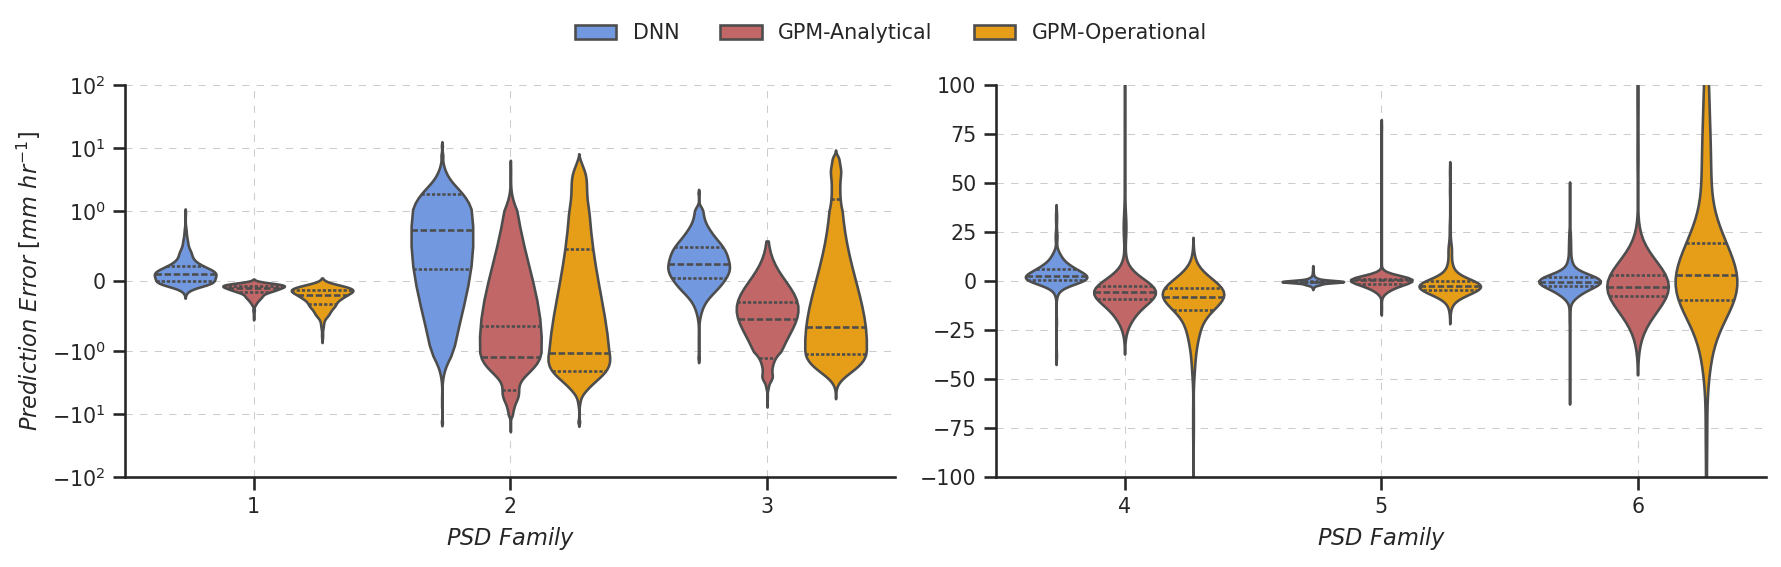

In [36]:
# Split the DataFrame into two groups: first 3 PSD families and the rest
df_first3 = df_rain_err[df_rain_err['kmeans'].isin([1, 2, 3])]  # Adjust indices if needed
df_rest = df_rain_err[~df_rain_err['kmeans'].isin([1, 2, 3])]

# Adjust figsize to reduce total width while preserving subplot ratios
fig, (ax1, ax2) = plt.subplots(
    1, 2, 
    figsize=(12, 3.5),  # Reduced width (12 instead of 16), same height (4)
    dpi=150, 
)


# Plot 1: First 3 PSD Families (symlog scale)
g1 = sns.violinplot(
    data=df_first3, x='kmeans', y='r_pred_err', hue='source', 
    palette=['cornflowerblue', 'indianred', 'orange'], 
    saturation=0.8, ax=ax1, gap=0.1, inner="quart", 
    density_norm='width', legend=True # Disable legend here
)
ax1.set_ylabel(r"$Prediction \ Error \ [mm \ hr^{-1}]$")
ax1.set_yscale('symlog', linthresh=1)  # Use symlog to handle near-zero errors
ax1.set_ylim(-100, 100)  # Adjust limits if needed
ax1.grid(True, linestyle='--', lw=0.5, dashes=[7, 7], which='both')
ax1.get_legend().remove()  # Remove the subplot legend

# Plot 2: Remaining Families (linear scale)
g2 = sns.violinplot(
    data=df_rest, x='kmeans', y='r_pred_err', hue='source', 
    palette=['cornflowerblue', 'indianred', 'orange'], 
    saturation=0.8, ax=ax2, gap=0.1, inner="quart", 
    density_norm='width', legend=False
)
ax2.set_ylabel("")  # Remove redundant y-label
ax2.set_ylim(-100, 100)  # Match the original scale
ax2.grid(True, linestyle='--', lw=0.5, dashes=[7, 7])

# Shared settings
for ax in [ax1, ax2]:
    ax.set_xlabel(r"$PSD \ Family$")
    sns.despine(ax=ax)

# Add a unified legend below both plots
handles, labels = ax1.get_legend_handles_labels()

# Add a single legend centered above both subplots
fig.legend(
    handles, labels,
    loc='lower center',          # Anchor point: bottom of the legend
    bbox_to_anchor=(0.5, 0.98), # Position: 50% horizontally, 5% above the figure
    ncol=3,
    frameon=False
)

plt.tight_layout()  # Ensure panels don’t overlap
plt.savefig(f'{path}/images/violin_rain_parm_split.svg', bbox_inches='tight')

Now, we can compute variance and IQRs for each retrieval at each PSD family

In [37]:
var = (
    df_rain_err[["r_pred_err", "source", "kmeans"]]
    .groupby(["source", "kmeans"])
    .var()
    .unstack(level=1)
    .assign(statistic="Variance")
).reset_index().set_index(["statistic", "source"])

iqrs = (df_rain_err[["r_pred_err", "source", "kmeans"]]
 .groupby(["source", "kmeans"])
 .quantile([0.25, 0.75])
 .rename_axis(index=["source", "kmeans", "quantile"])
 .unstack(level=1)
 .pipe(
     lambda quantiles: pd.DataFrame({
                col: quantiles.loc[(slice(None), 0.75), col].values
                     - quantiles.loc[(slice(None), 0.25), col].values
                for col in quantiles.columns
            }, index=quantiles.index.get_level_values(0).unique())  # Keep only 'source' level index
        )
        .assign(statistic="IQR")
    ).reset_index().set_index(["statistic", "source"])

var_iqrs = pd.concat([var, iqrs], axis=0)
var_iqrs

r_pred_err                                  \
                                   1         2         3           4   
statistic source                                                       
Variance  DNN               0.029342  5.749040  0.141942   45.684925   
          GPM-Analytical    0.006621  8.253061  1.090519  221.250734   
          GPM-Operational   0.020146  8.141951  6.742931  296.952624   
IQR       DNN               0.211696  1.688344  0.435977    5.427453   
          GPM-Analytical    0.097851  3.577018  1.010502    6.823430   
          GPM-Operational   0.195433  2.530850  2.669109   11.272962   

                                                   
                                   5            6  
statistic source                                   
Variance  DNN               1.677252    64.030762  
          GPM-Analytical   33.111149   902.180848  
          GPM-Operational  63.444168  1418.403280  
IQR       DNN               0.932594     4.493565  
          GPM-Analytical    2.887449    10.544024  
          GPM-Operational   4.760014    29.255953

### Other performance metrics 
We can also compute the root mean square error ($RMSE$), the mean absolute error ($MAE$) and the Correlation Coefficient ($R^2$)

In [38]:
def metrics_pd(x, xpred):
    """
    Function that computes the Root Mean Square Error, the Mean Absolute Error 
    and the Correlation Coefficient between the 'True' parameter and the estimate parameter
    param x: True parameter values
    param xpred: Estimated parameter values
    """
    xpred = xpred.astype(float)
    x = x.astype(float)
    x = x[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    xpred = xpred[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x)
    corr = np.corrcoef(x, xpred)**2.
    return pd.Series([rmse, mae, corr[0, 1]], index=["RMSE", "MAE", "R2"])

In [39]:
# Performance metrics for the DNN retreival
metrics_dnn = metrics_pd(df_r.r, df_dnn_r.r_dnn)
# Performance metrics for the GPM-Analytical retreival
metrics_GPM_ana = metrics_pd(df_r.r, df_gpm_ana_r.r_dm_gm_mu_3)
# Performance metrics for the GPM-Operational retreival
metrics_GPM_op = metrics_pd(df_r.r, df_gpm_op_r.r_gpm_operational)
pd.concat([metrics_dnn, metrics_GPM_ana, metrics_GPM_op], axis=1, levels=[keys], keys=keys).T


,RMSE,MAE,R2
DNN,4.222360,1.723046,0.934960
GPM-baseline,12.121793,3.609503,0.621796


In [40]:
# function for handling legend (https://github.com/mwaskom/seaborn/issues/1440#issuecomment-397721901)
def subtitle_legend(ax, legend_format):
    new_handles = []
    
    handles, labels = ax.get_legend_handles_labels()
    label_dict = dict(zip(labels, handles))
    
    #Means 2 labels were the same
    if len(label_dict) != len(labels):
        raise ValueError("Can not have repeated levels in labels!")
    
    for subtitle, level_order in legend_format.items():
        #Roll a blank handle to add in the subtitle
        # blank_handle = Patch(visible=True, label=subtitle, lw=1)
        blank_handle = Patch(visible=False, label=subtitle, lw=1)
        new_handles.append(blank_handle)
        
        for level in level_order:
            handle = label_dict[level]
            new_handles.append(handle)

    #Labels are populated from handle.get_label() when we only supply handles as an arg
    legend = ax.legend(handles=new_handles)

    #Turn off DrawingArea visibility to left justify the text if it contains a subtitle
    for draw_area in legend.findobj(DrawingArea):
        for handle in draw_area.get_children():
            if handle.get_label() in legend_format:
                draw_area.set_visible(False)
    legend._legend_box.align = "left"
    return legend


## Checking performance issues in the DNN retrieval

In [41]:
dnn = pd.concat([df_rain_err[df_rain_err['source'] == "DNN"], df_plot[['dm', 'log10_nw', 'mu', "mu_pred_err"]][df_plot['source'] == "DNN"]], axis=1)
gpma = pd.concat([df_rain_err[df_rain_err['source'] == "GPM-Analytical"], df_plot[['dm', 'log10_nw', "mu", "mu_pred_err"]][df_plot['source'] == "GPM-Analytical"]], axis=1)
gpmo = pd.concat([df_rain_err[df_rain_err['source'] == "GPM-Operational"].reset_index(), df_plot[['dm', 'log10_nw', "mu", "mu_pred_err"]][df_plot['source'] == "DNN"].reset_index()], axis=1, )

In [42]:
dnn_pos = dnn[dnn['r_pred_err'] >= 0]
dnn_neg = dnn[dnn['r_pred_err'] < 0]
gpma_pos = gpma[gpma['r_pred_err'] >= 0]
gpma_neg = gpma[gpma['r_pred_err'] < 0]
gpmo_pos = gpmo[gpmo['r_pred_err'] >= 0]
gpmo_neg = gpmo[gpmo['r_pred_err'] < 0]

In [43]:
gpma_pos.loc[207] = 0
gpma_pos.loc[208] = 0
gpma_pos.at[207, 'kmeans'] = 1
gpma_pos.at[208, 'kmeans'] = 3

In [44]:
gpmo_pos.loc[312] = 0
gpmo_pos.at[312, 'kmeans'] = 1

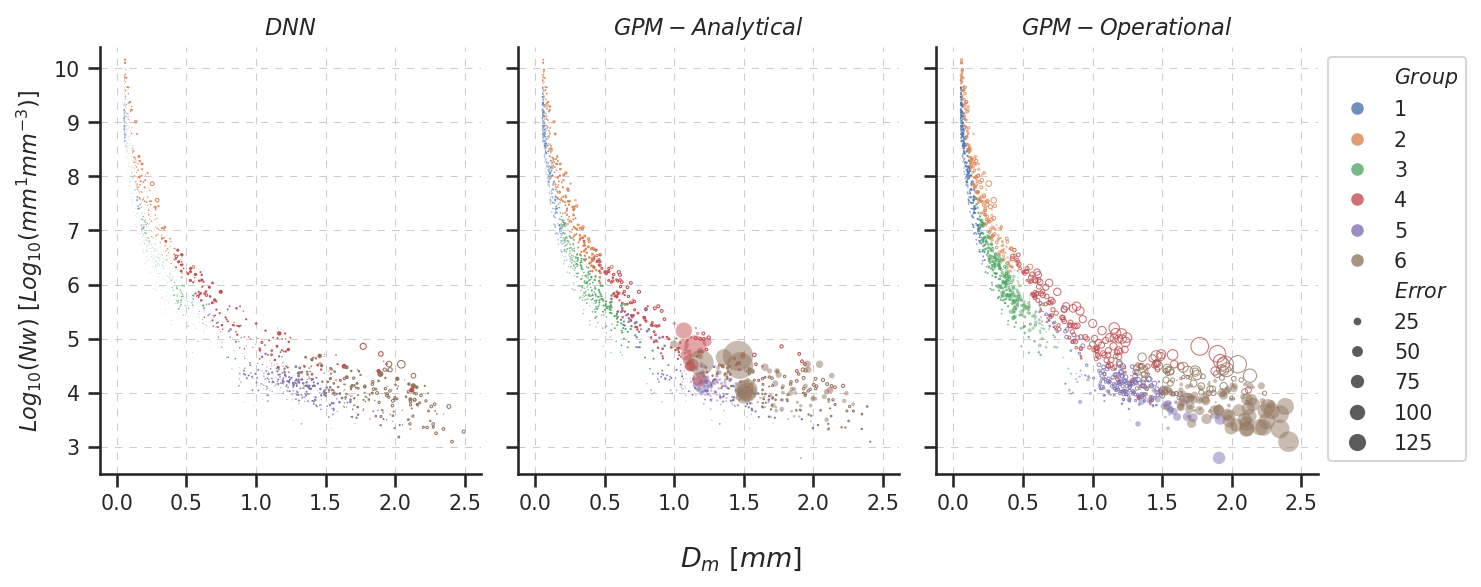

In [45]:
# Plotting results 
fig, axs = plt.subplot_mosaic([['a)', "b)", "c)"]], figsize=(10,4), sharey=True, sharex=True)

norm = (0, 250)
error_dnn_neg = np.abs(dnn_neg["r_pred_err"])
# DNN
ax = axs['a)']
# Scatter plot of Dm and Nw
sc = sns.scatterplot(data=dnn_neg, x='dm', y='log10_nw', hue='kmeans', 
                     size=error_dnn_neg,
                     sizes=(np.min(error_dnn_neg), np.max(error_dnn_neg)),
                     size_norm=norm,
                     ax=ax, palette=sns.color_palette('deep', 6), 
                     alpha=1,
                     legend=False,  
                     # legend=True,
                     )
for dots in sc.collections:
    facecolors = dots.get_facecolors()
    dots.set_edgecolors(facecolors.copy())
    dots.set_facecolors('none')
    dots.set_linewidth(0.5)

error_dnn_pos = np.abs(dnn_pos["r_pred_err"])

sns.scatterplot(data=dnn_pos, x='dm', y='log10_nw', hue='kmeans', 
                     size='r_pred_err',
                     sizes=(np.min(error_dnn_pos), np.max(error_dnn_pos)),
                     size_norm=norm,
                     ax=ax, palette=sns.color_palette('deep', 6), 
                     alpha=1,
                     legend=False,  
                     )
ax.set_xlabel(r"")
ax.set_ylabel(r"$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax.set_title(r"$DNN$");


# GPM-Analytical
ax1 = axs['b)']
# Scatter plot of Dm and Nw
error_gpma_neg = np.abs(gpma_neg['r_pred_err'])

sc2 = sns.scatterplot(data=gpma_neg, x='dm', y='log10_nw', hue='kmeans', 
                      size=error_gpma_neg,
                      sizes=(np.nanmin(error_gpma_neg), np.nanmax(error_gpma_neg)),
                      size_norm=norm,
                      ax=ax1, palette=sns.color_palette('deep', 6), 
                      alpha=1,
                      legend=False, 
                      # legend=True,
                      edgecolor=None,
                      )

for dots in sc2.collections:
    facecolors = dots.get_facecolors()
    dots.set_edgecolors(facecolors.copy())
    dots.set_facecolors('none')
    dots.set_linewidth(0.5)

error_gpma_pos = gpma_pos['r_pred_err']

sns.scatterplot(data=gpma_pos, x='dm', y='log10_nw', hue='kmeans', 
                      size='r_pred_err',
                      sizes=(np.nanmin(error_gpma_pos), np.nanmax(error_gpma_pos)),
                      size_norm=norm,
                      ax=ax1, palette=sns.color_palette('deep', 6), 
                      alpha=0.5,
                      legend=False, 
                      # legend=True,
                      edgecolor=None,
                      )
ax1.set_xlabel(r"")
ax1.set_ylabel(r"$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.set_title(r"$GPM-Analytical$");




# left panel
ax2 = axs['c)']
# Scatter plot of Dm and Nw
error_gpmo_neg = np.abs(gpmo_neg["r_pred_err"])

g2 = sns.scatterplot(data=gpmo_neg, x='dm', y='log10_nw', hue='kmeans', 
                      size=error_gpmo_neg,
                      sizes=(np.nanmin(error_gpmo_neg),np.nanmax(error_gpmo_neg)),
                      size_norm=norm,
                      ax=ax2, palette=sns.color_palette('deep', 6), 
                      alpha=0.8,
                      legend="brief",
                      edgecolor=None,
                      )

for dots in g2.collections:
    facecolors = dots.get_facecolors()
    dots.set_edgecolors(facecolors.copy())
    dots.set_facecolors('none')
    dots.set_linewidth(0.5)

error_gpmo_pos = gpmo_pos['r_pred_err']
sns.scatterplot(data=gpmo_pos, x='dm', y='log10_nw', hue='kmeans', 
                      size='r_pred_err',
                      sizes=(np.nanmin(error_gpmo_pos),np.nanmax(error_gpmo_pos)),
                      size_norm=norm,
                      ax=ax2, palette=sns.color_palette('deep', 6), 
                      alpha=0.5,
                      legend=False, 
                      edgecolor=None,
                      )

ax2.set_xlabel(r"")
ax2.set_ylabel(r"$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax2.set_title(r"$GPM-Operational$");
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
handles, labels = ax2.get_legend_handles_labels()


legend_format = {r'$Group$': labels[1:7],
                 r'$Error$': labels[8:],
                }
subtitle_legend(ax2, legend_format=legend_format)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
fig.supxlabel(r"$D_m \ [mm]$", y= 0.03)
ax.set_ylim(2.5, 10.4)

fig.tight_layout()
plt.savefig(f'{path}/images/error_scatter_dnn.svg',  bbox_inches='tight')